In [1]:
import os

import utils
from Ford_dataset_s import SatGrdDatasetFordPresentation, train_logs, train_logs_img_inds, test_logs, test_logs_img_inds
from models_ford_s import ModelFord
from utils_s import render_point_cloud
# from models_ford import ModelFord as ModelFord_orig
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt 
import matplotlib.gridspec as gridspec
import numpy as np 
# from VGG import Unet, space2channel

from train_ford_3DOF_s import parse_args

args = parse_args()
# save_path ='ModelsFord/3DoF/Log_3lat20.0m_lon20.0m_rot10.0_Nit1_CrossAttn_FL_SL_3D_Uncertainty'
save_path = 'Log_3lat20.0m_lon20.0m_rot10.0_Nit1_CrossAttn_FL_SL_3D_Uncertainty'
args.train_log_start = 3

# cameras = ['FL', 'SL'] 
# args.image_H = 256 #256
# args.image_W = 1024#1024
# args.cameras = cameras
# args.batch_size = 1
# args.lifting = '3D' #homography

test_set = SatGrdDatasetFordPresentation(logs=test_logs[args.train_log_start:args.train_log_start+1],
                                logs_img_inds=test_logs_img_inds[args.train_log_start:args.train_log_start+1],
                                shift_range_lat=args.shift_range_lat, shift_range_lon=args.shift_range_lon,
                                rotation_range=args.rotation_range, whole=args.test_whole, 
                                H = args.image_H, W = args.image_W, cameras=args.cameras, mode='train') 
testloader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, pin_memory=True,
                            num_workers=2, drop_last=False)





device = 'cuda' #torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
args.Rs = {key:item.to(device) for key, item in test_set.Rs.items()}
args.Ts = {key:item.to(device) for key, item in test_set.Ts.items()}
args.Ks = {key:item.to(device) for key, item in test_set.Ks.items()}
net = ModelFord(args).to(device)
net.load_state_dict(torch.load(os.path.join(save_path, 'model_1.pth')), strict=False)

len(test_set), args.batch_size

Error importing huggingface_hub.hf_api: cannot import name 'COMMON_SAFE_ASCII_CHARACTERS' from 'charset_normalizer.constant' (/home/dimitris/miniconda3/envs/condapy310/lib/python3.10/site-packages/charset_normalizer/constant.py)
/mnt/c/Users/dimitris/Desktop/MyFiles/diplomatikh/pytorch-tensorflow/pytorch/Cross-View-Localization/server client with kafka


/home/dimitris/miniconda3/envs/condapy310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimitris/miniconda3/envs/condapy310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dimitris/miniconda3/envs/condapy310/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847130/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  re

(3511, 1)

In [2]:
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import cv2

def get_corr_map(net, sat_img_norot_notran):
    '''
    in model ford self.return_for_presentation must be uncommented
    '''
    uncertainty_map = net.return_for_presentation[0]     #torch.Size([1, 1, 256, 256])         
    grd2sat_proj_feat = net.return_for_presentation[1]    #torch.Size([1, 64, 256, 256])
    sat_feat_list, _ = net.SatFeatureNet(sat_img_norot_notran)
    sat_feat = sat_feat_list[2] #torch.Size([1, 64, 256, 256])


    with torch.no_grad():
        g2s_feat = F.normalize(grd2sat_proj_feat.reshape(1,-1)).reshape(1,64,256,256)
        s_feat = sat_feat.reshape(1, -1, 256, 256) # [B, C, H, W]->[1, B*C, H, W]

        corr = F.conv2d(sat_feat, g2s_feat, padding=128, groups=1)[0]
        corr = corr[:, :256, :256]
        denominator = F.avg_pool2d(sat_feat.pow(2), (256, 256), stride=1, divisor_override=1)
        denominator = torch.sum(denominator, dim=1) * uncertainty_map[:, 0]
        denominator = torch.maximum(torch.sqrt(denominator), torch.ones_like(denominator) * 1e-6) 
        corr = 2 - 2 * corr / denominator

        corr.shape
        corr = (corr - corr.min())/(corr.max() - corr.min())
        corr = 1-corr
        corr = corr **3
        corr = corr.permute([1,2,0]).cpu().numpy().copy()
        corr = np.concatenate((np.zeros_like(corr), np.zeros_like(corr), corr), axis=2)

        return corr
    
def calculate_tranjectories(g_lats, g_lons, gt_shift_v_meters, gt_shift_u_meters, pred_shift_v_meters, pred_shift_u_meters, yaws):
    y, x = utils.gps2meters_torch(torch.tensor(g_lats).cpu(), torch.tensor(g_lons).cpu(), torch.tensor(g_lats[0]).cpu(), torch.tensor(g_lons[0]).cpu())
    x = -x ;y = -y

    xy_shift_gt = torch.stack((torch.tensor(gt_shift_v_meters), torch.tensor(gt_shift_u_meters)))
    xy_shift_pred = torch.stack((torch.tensor(pred_shift_v_meters), torch.tensor(pred_shift_u_meters)))
    xy_error = xy_shift_gt - xy_shift_pred

    yaws = torch.tensor(yaws) 
    yaws_rad = (yaws * torch.pi / 180.0) 

    row_1 = torch.stack([torch.cos(yaws_rad), torch.sin(yaws_rad)], dim =1).unsqueeze(1)
    row_2 = torch.stack([-torch.sin(yaws_rad), torch.cos(yaws_rad)], dim =1).unsqueeze(1)
    rot_mat = torch.concat([row_1,row_2], dim=1)

    xy_shift_gt_new = rot_mat @ xy_shift_gt.T.unsqueeze(-1)
    xy_shift_gt_new = xy_shift_gt_new.squeeze(-1).T
    xy_error_new = rot_mat @ xy_error.T.unsqueeze(-1)
    xy_error_new = xy_error_new.squeeze(-1).T

    traj_gt = torch.stack((x,y))
    traj_gps = traj_gt + xy_shift_gt_new
    traj_net = traj_gt + xy_error_new

    return traj_gt, traj_gps, traj_net, xy_shift_gt_new, xy_error_new

def tranjectories2image(trajctories_1, trajctories_2, trajctories_3, image):
    
    image_size = image.shape[0]
    image_meters = 112.6
    image_center = image_size//2
    pixelspermeter = image_size/image_meters

    trajctories_1_pixels = trajctories_1 * pixelspermeter + image_center; trajctories_1_pixels = trajctories_1_pixels.type(torch.int64)
    trajctories_2_pixels = trajctories_2 * pixelspermeter + image_center; trajctories_2_pixels = trajctories_2_pixels.type(torch.int64)
    trajctories_3_pixels = trajctories_3 * pixelspermeter + image_center; trajctories_3_pixels = trajctories_3_pixels.type(torch.int64)

    # image[trajctories_1_pixels[0], trajctories_1_pixels[1], :] = 0

    cv2.circle(image, (trajctories_1_pixels[1, -1].item(), trajctories_1_pixels[0, -1].item()), radius=2, color=(0, 0, 255), thickness=2)
    cv2.circle(image, (trajctories_2_pixels[1, -1].item(), trajctories_2_pixels[0, -1].item()), radius=2, color=(255, 0, 0), thickness=2)
    cv2.circle(image, (trajctories_3_pixels[1, -1].item(), trajctories_3_pixels[0, -1].item()), radius=2, color=(0, 255, 255), thickness=2)

    return image

def load_satelite_image(sat_map_path, sat_map_side_length):
    sat_map = Image.open(sat_map_path).convert('RGB')

In [3]:
from kafka import KafkaProducer, KafkaConsumer, TopicPartition
import msgpack
import simplejpeg



def dict_to_bytes(data_dict):
    return msgpack.packb(data_dict, use_bin_type=True)


def bytes_to_dict(json_str):
    return msgpack.unpackb(json_str, raw=False)


def encode_pytorch_image(img):
    """
    Takes a pytorch tensor of shape (3,H,W) and encodes it to bytes, jpeg compression is used 
    img is float32 and values are in range (0,1)
    """
    img_numpy = img * 255.0 
    img_numpy = torch.permute(img_numpy, (1,2,0)).contiguous()
    img_numpy = img_numpy.to(torch.uint8).numpy()
    grd_img_bytes = simplejpeg.encode_jpeg(img_numpy)

    return grd_img_bytes

def decode_pytorch_image(img_bytes):
    """
    Takes an encoded pytorch images that is in the form of bytes and decodes it 
    return tensor of shape (3,H,W)
    """
    img_numpy = simplejpeg.decode_jpeg(img_bytes)
    img_torch = torch.tensor(img_numpy, dtype=torch.float32) / 255.0
    img_torch = torch.permute(img_torch, [2,0,1]).contiguous()

    return img_torch

topic_name = '3DOF'

producer = KafkaProducer(bootstrap_servers=['localhost:9092'],
                         )

consumer = KafkaConsumer(#topic = topic_name,
                         bootstrap_servers=['localhost:9092'],
                         auto_offset_reset='latest', #will start consuming from the last message in the topic 
                         #consumer_timeout_ms=10000 #stop consumer from waiting for messages after 1000ms of not reciving any messages 
                         )

tp1 = TopicPartition(topic_name, 1)
consumer.assign([tp1])


In [4]:
from PIL import Image

sat_map_path = '../../../datasets/Ford/2017-08-04/V2/Log4/SatelliteMaps_18/42.32144438527925_-83.23340638391272.png'
sat_map = Image.open(sat_map_path).convert('RGB')
sat_map = np.array(sat_map)
# meters = 112.6
# pixels = meters / test_set.meters_per_pixel
pixels = 512 
sat_map_center = sat_map.shape[0]//2
sat_map = sat_map[sat_map_center-pixels//2:sat_map_center+pixels//2, sat_map_center-pixels//2:sat_map_center+pixels//2]
sat_map = sat_map.astype(np.float32)/255.0
sat_map = np.flip(sat_map, axis = -1).copy()

data send
data recived
tensor([90.9091]) tensor([63.6364]) tensor([1.], device='cuda:0')
tensor(102.5554) tensor(17.7312) tensor(0.7607)


/tmp/ipykernel_963637/4148201055.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y, x = utils.gps2meters_torch(torch.tensor(g_lats).cpu(), torch.tensor(g_lons).cpu(), torch.tensor(g_lats[0]).cpu(), torch.tensor(g_lons[0]).cpu())


data send
data recived
tensor([90.8015]) tensor([65.3488]) tensor([0.9980], device='cuda:0')
tensor(102.3701) tensor(19.2968) tensor(0.7373)
data send
data recived
tensor([90.4790]) tensor([67.0545]) tensor([0.9921], device='cuda:0')
tensor(102.2515) tensor(20.6064) tensor(0.6995)
data send
data recived
tensor([89.9429]) tensor([68.7468]) tensor([0.9823], device='cuda:0')
tensor(101.5291) tensor(26.5299) tensor(0.6977)
data send
data recived
tensor([89.1954]) tensor([70.4188]) tensor([0.9686], device='cuda:0')
tensor(100.1646) tensor(5.5728) tensor(0.7758)
data send
data recived
tensor([88.2394]) tensor([72.0641]) tensor([0.9511], device='cuda:0')
tensor(98.1340) tensor(6.1408) tensor(0.8248)
data send
data recived
tensor([87.0787]) tensor([73.6761]) tensor([0.9298], device='cuda:0')
tensor(98.0540) tensor(5.0405) tensor(0.6446)
data send
data recived
tensor([85.7178]) tensor([75.2485]) tensor([0.9048], device='cuda:0')
tensor(95.6108) tensor(9.5175) tensor(0.8071)
data send
data reciv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data recived
tensor([62.6411]) tensor([87.5356]) tensor([0.4818], device='cuda:0')
tensor(67.0781) tensor(78.4890) tensor(0.3697)


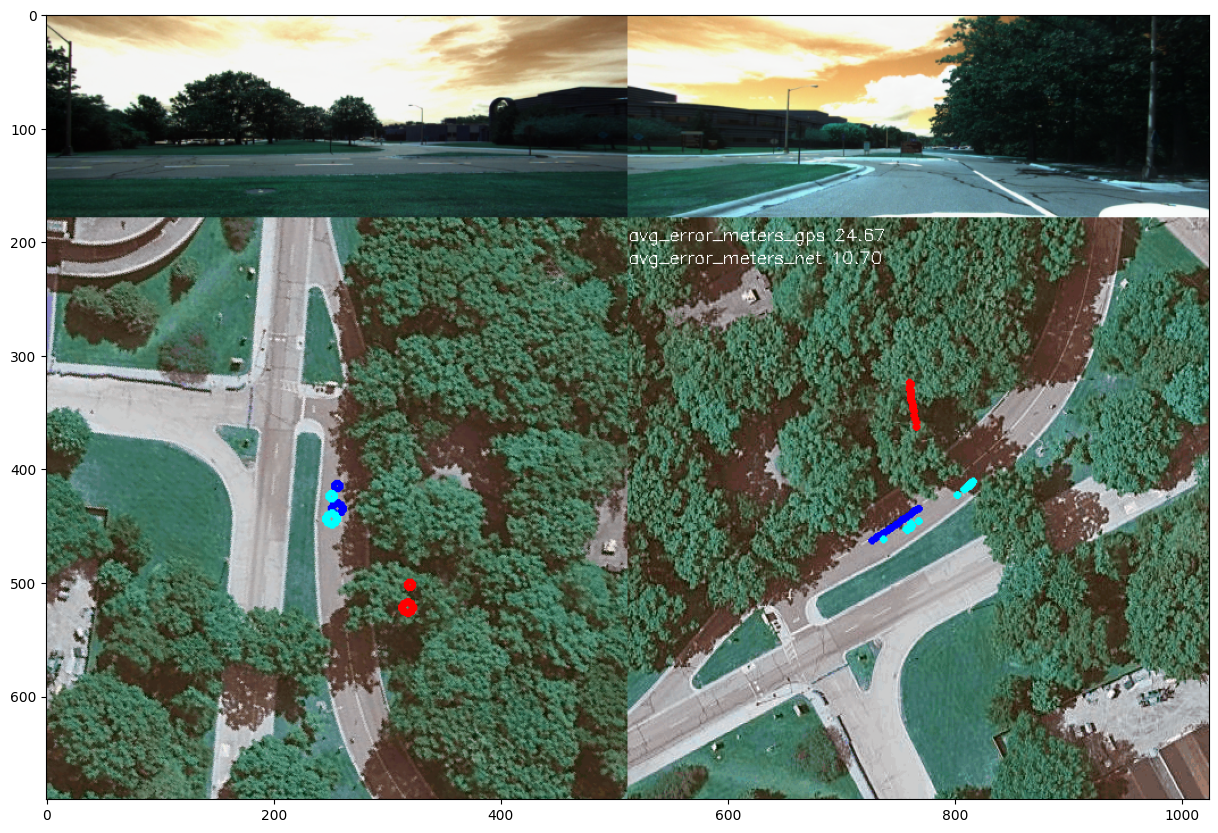

In [5]:
data_id = 0
from IPython.display import clear_output
from io import BytesIO
from PIL import Image
import cv2



s_lats = []; s_lons = []
g_lats = []; g_lons = []
gt_shift_u_meters = []; gt_shift_v_meters = []
pred_shift_u_meters = []; pred_shift_v_meters = []

yaws = []
for data in testloader:
    sat_img, grd_imgs, gt_shift_u, gt_shift_v, gt_heading, grd_names, sat_img_norot_notran, s_lat, s_lon, g_lat, g_lon, yaw = [[camera.to(device) if type(camera) == torch.Tensor else camera for camera in item] if type(item)== list else item.to(device) if type(item) == torch.Tensor else item for item in data]
    s_lats.append(s_lat); s_lons.append(s_lon)
    g_lats.append(g_lat); g_lons.append(g_lon)
    yaws.append(yaw)

    image_0 = encode_pytorch_image(grd_imgs[0].cpu().squeeze(0))
    image_1 = encode_pytorch_image(grd_imgs[1].cpu().squeeze(0))

    data_send = {'image_0':image_0, 'image_1':image_1, 'data_id':data_id}
    data_send_bytes = dict_to_bytes(data_send)

    producer.send(topic_name, value=data_send_bytes, partition=0)
    print('data send')
    for message in consumer:
        print('data recived')
        data_recived_bytes = message.value 
        data_recived = bytes_to_dict(data_recived_bytes)
        break

    pred_u = torch.tensor(data_recived['pred_u'])
    pred_v = torch.tensor(data_recived['pred_v'])
    pred_orien = torch.tensor(data_recived['pred_orien'])

    pred_u_pixels = pred_u.cpu()/test_set.meters_per_pixel
    pred_v_pixels = pred_v.cpu()/test_set.meters_per_pixel

    
    gt_shift_u_pixels = gt_shift_u.cpu() * test_set.shift_range_meters_lon/ test_set.meters_per_pixel
    gt_shift_v_pixels = gt_shift_v.cpu() * test_set.shift_range_meters_lat/ test_set.meters_per_pixel
    
    gt_shift_u_meters.append(gt_shift_u.cpu() * test_set.shift_range_meters_lon)
    gt_shift_v_meters.append(gt_shift_v.cpu() * test_set.shift_range_meters_lat)
    pred_shift_u_meters.append(pred_u.cpu())
    pred_shift_v_meters.append(pred_v.cpu())


    # fig = plt.figure(figsize=(20, 20))
    # gs = gridspec.GridSpec(4, 2, wspace=0, hspace=0)
    # ax0 = fig.add_subplot(gs[0, 0:2])# This spans all columns in the first row
    # ax10 = fig.add_subplot(gs[1, 0])
    # ax11 = fig.add_subplot(gs[1, 1])

    sat_map_center = 512//2

    grd_imgs_plt = torch.cat((grd_imgs[1].cpu(), grd_imgs[0].cpu()), dim = -1).squeeze(0).permute([1,2,0])
    sat_img_norot_notran_plt = sat_img_norot_notran.cpu().squeeze(0).permute([1,2,0])
    # img2_plt = img2.squeeze(0).permute([1,2,0])
    # img3_plt = img3.squeeze(0).permute([1,2,0])
    sat_img_plt = sat_img.cpu().squeeze(0).permute([1,2,0])


    a = 20
    gt_theta =  -gt_heading.cpu() * test_set.rotation_range * np.pi/180
    gt_shift_u_a =  -np.sin(gt_theta) * a
    gt_shift_v_a =  -np.cos(gt_theta) * a

    pred_theta = - pred_orien.cpu() * test_set.rotation_range * np.pi/180 
    pred_shift_u_a =  -np.sin(pred_theta) * a
    pred_shift_v_a =  -np.cos(pred_theta) * a

    print(gt_shift_u_pixels, gt_shift_v_pixels, gt_heading)
    print(pred_u_pixels, pred_v_pixels, pred_orien)#, pred_u_pixels, pred_v_pixels)
    
    

    sat_img_norot_notran_cv2 = cv2.cvtColor(sat_img_norot_notran_plt.numpy().copy(), cv2.COLOR_BGR2RGB)
    cv2.circle(sat_img_norot_notran_cv2, (sat_map_center, sat_map_center), radius=5, color=(0, 0, 255), thickness=5)
    cv2.circle(sat_img_norot_notran_cv2, (sat_map_center, sat_map_center-a), radius=3, color=(0, 0, 255), thickness=3)
    cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels), int(sat_map_center+gt_shift_v_pixels)), radius=5, color=(255, 0, 0), thickness=5)
    cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels+gt_shift_u_a), int(sat_map_center+gt_shift_v_pixels+gt_shift_v_a)), radius=3, color=(255, 0, 0), thickness=3)
    cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels-pred_u_pixels), int(sat_map_center+gt_shift_v_pixels-pred_v_pixels)), radius=5, color=(0, 255, 255), thickness=5)
    cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels-pred_u_pixels+gt_shift_u_a-pred_shift_u_a), int(sat_map_center+gt_shift_v_pixels-pred_v_pixels+pred_shift_v_a)), radius=3, color=(0, 255, 255), thickness=3)

    grd_imgs_cv2 = cv2.cvtColor(grd_imgs_plt.numpy().copy(), cv2.COLOR_BGR2RGB)
    grd_imgs_cv2 = cv2.resize(grd_imgs_cv2, (grd_imgs_cv2.shape[1]//2, int(grd_imgs_cv2.shape[0]*0.7),))

    sat_img_norot_notran_cv2 = cv2.resize(sat_img_norot_notran_cv2, (grd_imgs_cv2.shape[1]//2,)*2)
    if data_id==0: zeros_right = sat_map#np.zeros_like(sat_img_norot_notran_cv2)[:,:sat_img_norot_notran_cv2.shape[1],:] 


    traj_1, traj_2, traj_3, gps_shift, net_shift = calculate_tranjectories(g_lats, g_lons, gt_shift_v_meters, gt_shift_u_meters, pred_shift_v_meters, pred_shift_u_meters, yaws)
    zeros_right = tranjectories2image(traj_1, traj_2, traj_3, zeros_right)

    avg_error_meters_gps = gps_shift[0] ** 2 + gps_shift[1] **2; avg_error_meters_gps = avg_error_meters_gps.mean().item() ** 0.5
    avg_error_meters_net = net_shift[0] ** 2 + net_shift[1] **2; avg_error_meters_net = avg_error_meters_net.mean().item() ** 0.5

    zeros_right_text = cv2.putText(zeros_right.copy(), text = f'avg_error_meters_gps {avg_error_meters_gps:.2f}', org=(0, 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255))
    cv2.putText(zeros_right_text, text = f'avg_error_meters_net {avg_error_meters_net:.2f}', org=(0, 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255))

    sat_img_norot_notran_cv2 = np.concatenate((sat_img_norot_notran_cv2,zeros_right_text), axis=1)

    img = np.concatenate((grd_imgs_cv2, sat_img_norot_notran_cv2), axis=0)


    cv2.imshow('img', img)
    cv2.waitKey(1) 


    if data_id>16*1:break
    data_id+=1

cv2.destroyAllWindows() 

plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show() 

In [6]:
import sys 

3*256*1024, sys.getsizeof(image_0), len(image_0)

(786432, 62290, 62257)